# Sentence Embedding - Présentation générale

* Ce notebook présente différentes techniques de "Sentence Embeddings", permettant de générer des features à partir de phrases
* L'objectif est de pouvoir séparer les sentiments des tweets de façon automatique, via un T-SNE, qui permet une réduction des features en 2 dimensions
* C'est un notebook d'exemples afin de mieux comprendre la mise en oeuvre des techniques. Il n'est pas optimisé et doit être adapté à un nouveau contexte, en particulier sur les points suivants :
    * Le nettoyage des textes
    * les modèles BERT (model_type) idéalement pré-entraînés sur des données similaires au contexte
    * La taille des vecteurs (max_length)
    * Le batch_size
    * La perplexité du Tsne (perplexity à 30 par défaut)

# Préparation initiale dataset

## Récupération du dataset et filtres de données

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Fichier des tweets à récupérer sur : https://www.kaggle.com/crowdflower/twitter-airline-sentiment?select=Tweets.csv

path = '/content/drive/My Drive/Projet_8/data/source/Flipkart/'
data_T0 = pd.read_csv(path + "flipkart_com-ecommerce_sample_1050.csv")
print(data_T0.shape)

(1050, 15)


In [5]:
# On décompose la colonne product_category_tree et on ne garde que la première granularité
data_T0[["product_category", "product_category_tree"]] = data_T0["product_category_tree"].str.split(' >>', n=1, expand=True)
# display(data_T0.sample(5))

# On supprime également les 2 premiers éléments qui sont [" de product_category
data_T0["product_category"] = data_T0.product_category.str.slice(2)

# On récupère les colonnes utiles
data_T0 = data_T0[["product_category", "description"]]
display(data_T0)

,product_category,description
0,Home Furnishing,Key Features of Elegance Polyester Multicolor ...
1,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...
2,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...
3,Home Furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...
4,Home Furnishing,Key Features of Jaipur Print Cotton Floral Kin...
...,...,...
1045,Baby Care,Oren Empower Extra Large Self Adhesive Sticker...
1046,Baby Care,Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047,Baby Care,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048,Baby Care,Buy Wallmantra Medium Vinyl Sticker Sticker fo...


In [6]:
data_T0.product_category.value_counts()

,count
product_category,
Home Furnishing,150
Baby Care,150
Watches,150
Home Decor & Festive Needs,150
Kitchen & Dining,150
Beauty and Personal Care,150
Computers,150


## Nettoyage du texte

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [8]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [9]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@"))
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

data_T0['sentence_bow'] = data_T0['description'].apply(lambda x : transform_bow_fct(x))
data_T0['sentence_bow_lem'] = data_T0['description'].apply(lambda x : transform_bow_lem_fct(x))
data_T0['sentence_dl'] = data_T0['description'].apply(lambda x : transform_dl_fct(x))
data_T0.shape

(1050, 5)

In [10]:
data_T0.sample(5)

,product_category,description,sentence_bow,sentence_bow_lem,sentence_dl
63,Baby Care,Key Features of KOHL Wine Bag Yellow Easy to c...,key features kohl wine bag yellow easy carry g...,key feature kohl wine bag yellow easy carry gi...,key features of kohl wine bag yellow easy to c...
918,Home Furnishing,Buy The Intellect Bazaar Abstract Double Dohar...,buy the intellect bazaar abstract double dohar...,buy the intellect bazaar abstract double dohar...,buy the intellect bazaar abstract double dohar...
369,Computers,Buy Tenda 3G300M only for Rs. 3000 from Flipka...,buy tenda 3g300m 3000 flipkart.com only genuin...,buy tenda 3g300m 3000 flipkart.com only genuin...,buy tenda 3g300m only for rs . 3000 from flipk...
125,Beauty and Personal Care,Flipkart.com: Buy Sally Hansen La Cross 5 Pcs ...,flipkart.com buy sally hansen cross pcs festiv...,flipkart.com buy sally hansen cross pc festiva...,flipkart.com : buy sally hansen la cross 5 pcs...
1001,Baby Care,Key Features of Mom & Me Baby Girl's Bodysuit ...,key features mom baby girl bodysuit fabric cot...,key feature mom baby girl bodysuit fabric cott...,key features of mom & me baby girl 's bodysuit...


In [11]:
data_T0.to_csv("/content/drive/My Drive/Projet_8/data/cleaned/df_cleaned.csv", index=False)

# Préparation commune des traitements

In [12]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere


## Lecture dataset

In [13]:
data_T =  pd.read_csv("/content/drive/My Drive/Projet_8/data/cleaned/df_cleaned.csv")
print(data_T.shape)

(1050, 5)


In [14]:
l_cat = list(set(data_T['product_category']))
# print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(data_T.iloc[i]['product_category'])) for i in range(len(data_T))]

In [15]:
from nltk.tokenize import sent_tokenize, word_tokenize

data_T['length_bow'] = data_T['sentence_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data_T['length_bow'].max())
data_T['length_dl'] = data_T['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data_T['length_dl'].max())


max length bow :  379
max length dl :  632


## Fonctions communes

In [16]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, max_iter=2000,
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=2, title="Categories")
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=4, title="Clusters")
    plt.title('Représentation des produits par clusters')

    plt.show()
    print("ARI : ", ARI)


# Bag of word - Tf-idf

## Préparation sentences

In [17]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])
ctf_transform = ctf.transform(data_T[feat])

## Exécution des modèles

CountVectorizer : 
-----------------
ARI :  0.4213 time :  17.0


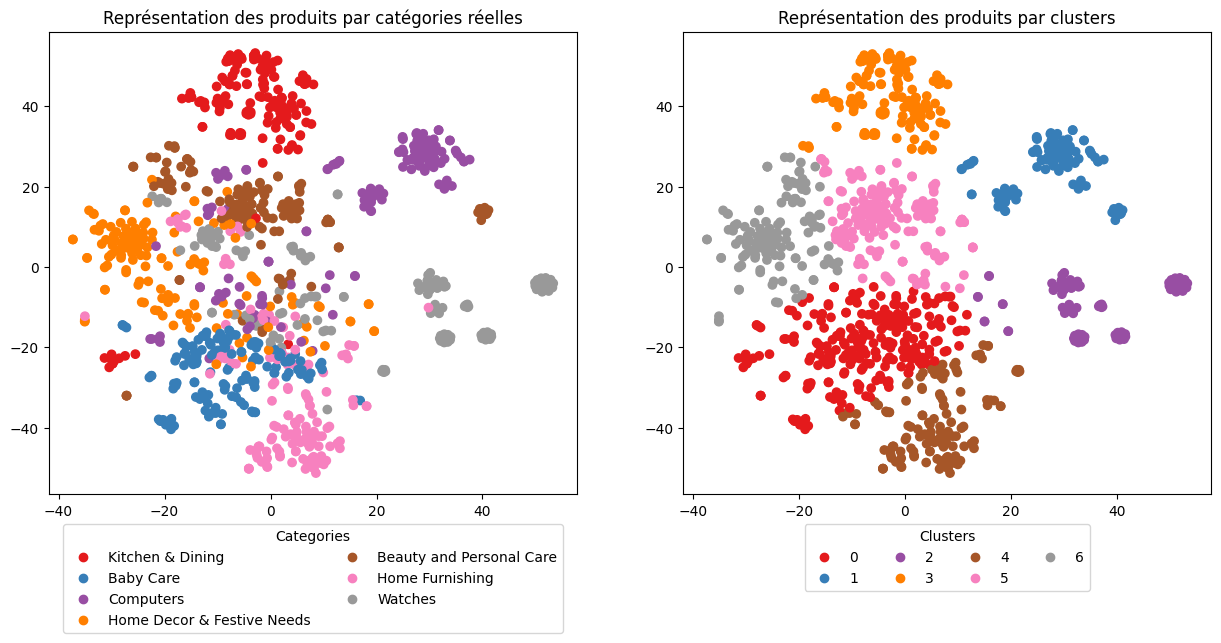

ARI :  0.4213

Tf-idf : 
--------
ARI :  0.4102 time :  13.0


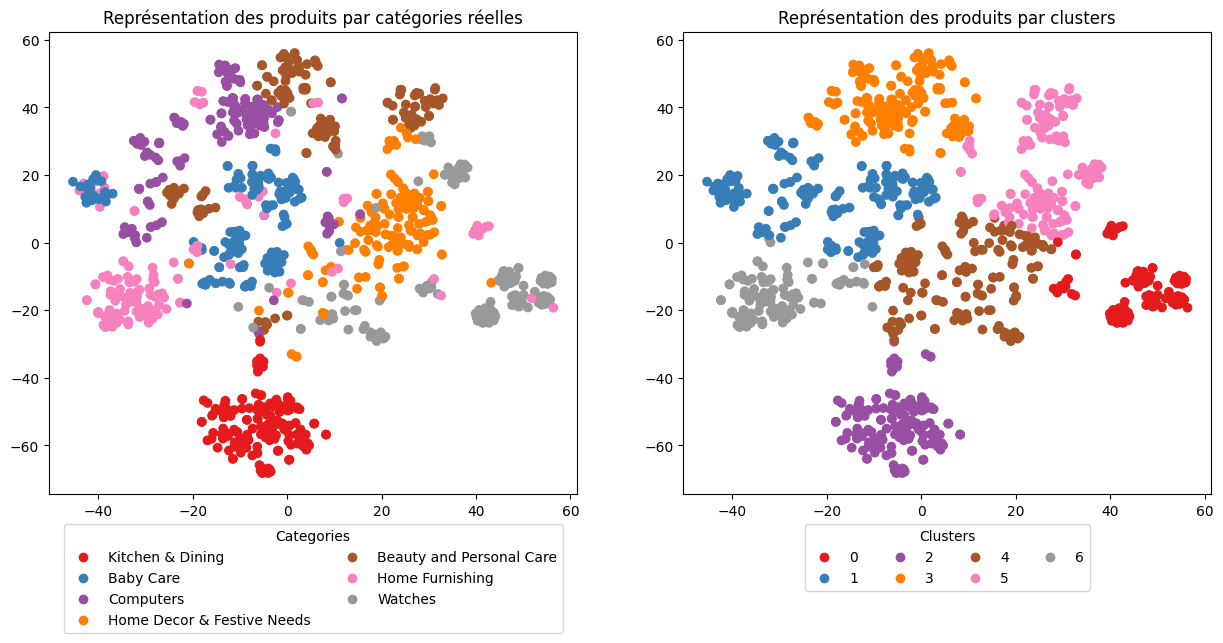

ARI :  0.4102


In [18]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# Word2Vec

In [19]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

## Création du modèle Word2Vec

In [20]:
import gensim

w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data_T['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [21]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4713
Word2Vec trained


In [22]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4714


## Création de la matrice d'embedding

In [23]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0

for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4714, 300)


## Création du modèle d'embedding

In [24]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input],word_vec)

embed_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 24, 300)             │       1,414,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 300)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,414,200 (5.39 MB)

 Trainable params: 1,414,200 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

## Exécution du modèle

In [25]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1']
Received: inputs=Tensor(shape=(32, 24))
  warnings.warn(msg)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1']
Received: inputs=Tensor(shape=(None, 24))
  warnings.warn(msg)


(1050, 300)

In [26]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.2159 time :  12.0


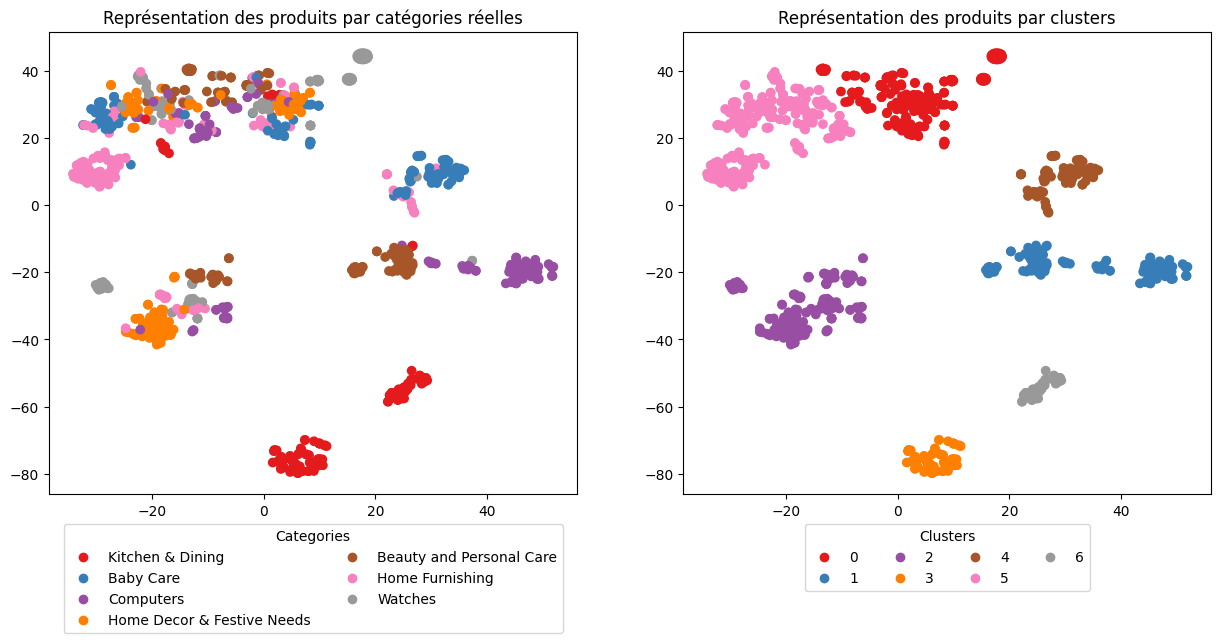

ARI :  0.2159


In [27]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# BERT

In [28]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.
TAPAS models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version. Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.


In [29]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.18.0
2.18.0
Num GPUs Available:  1
True


## Fonctions communes

In [30]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                      bert_tokenizer, max_length)

        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                 "input_mask" : attention_mask,
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [31]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [32]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

1/1 [==============================] - 0s 23ms/step
temps traitement :  26.0


In [33]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3256 time :  13.0


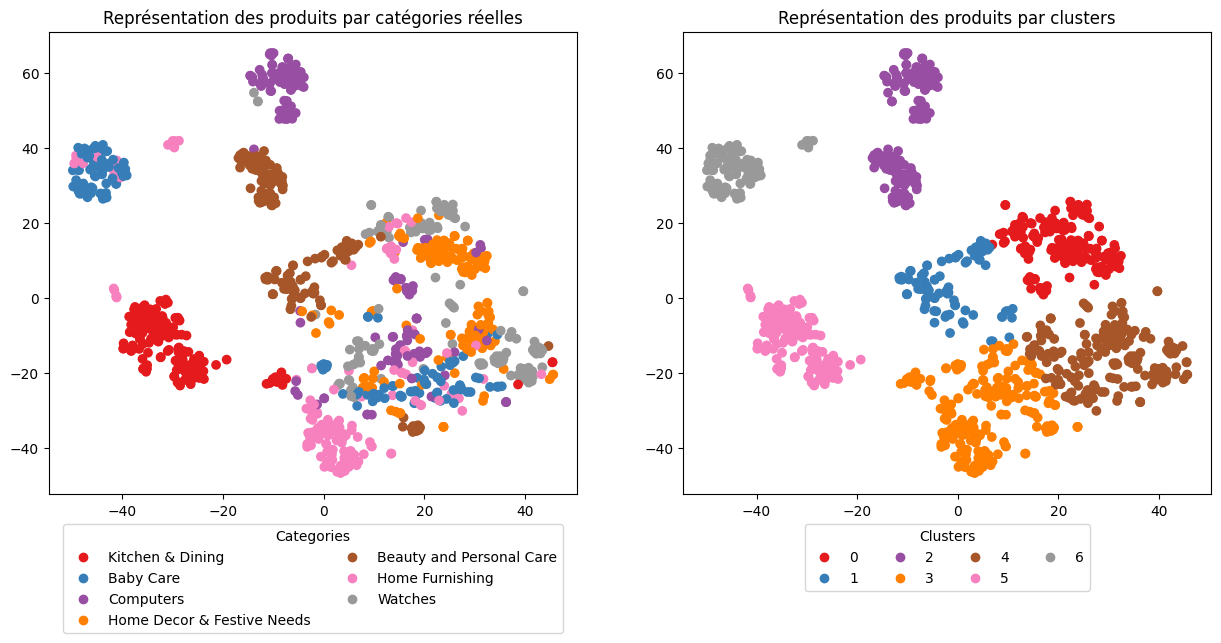

ARI :  0.3256


In [34]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## CamemBERT - le modèle français de BERT

In [35]:
from transformers import TFCamembertModel, CamembertTokenizer

# You can replace "camembert-base" with any other model from the table, e.g. "camembert/camembert-large".
model_name = "camembert-base"

In [36]:
max_length = 64
batch_size = 10
model_type = 'camembert-base'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [37]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

1/1 [==============================] - 0s 24ms/step
temps traitement :  23.0


In [38]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.308 time :  13.0


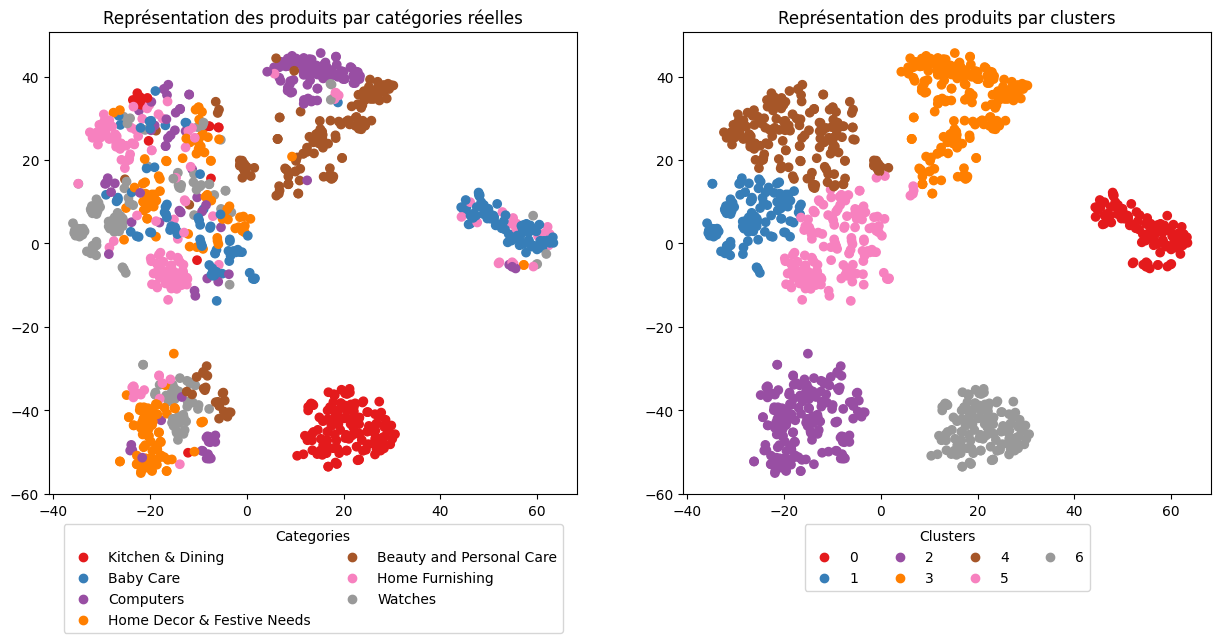

ARI :  0.308


In [39]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [40]:
break

SyntaxError: 'break' outside loop (<ipython-input-40-6aaf1f276005>, line 1)

## BERT hub Tensorflow

In [ ]:
pip install tensorflow_text

In [ ]:
import tensorflow_hub as hub
import tensorflow_text

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [ ]:
sentences = data_T['sentence_dl'].to_list()

In [ ]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='TFhub')

In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)

In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE - Universal Sentence Encoder

In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [ ]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [ ]:
batch_size = 10
sentences = data_T['sentence_dl'].to_list()

In [ ]:
features_USE = feature_USE_fct(sentences, batch_size)

In [ ]:
ARI, X_tsne, labels = ARI_fct(features_USE)

In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)